# Matrix Factorization
The next model I want to try is Matrix Factorization. Matrix Factorization aims to predict missing values in a user-item matrix (a matrix that stores every possible user and their interaction with every possible item) based on previous products the user has interacted with. 

It is a collaborative filtering technique that represents users and items in a lower dimensional latent space to make predictions. It is most effective when the data is constructed with the implicit feedback (reviewing a product means a positive interaction while not reviewing it is a negative interaction). As we have the rating that each user put in their review, we can adopt a weighted implicit feedback technique that assigns higher confidence to interactions with higher ratings.

While this has historically been a very effective approach, we need to see if matrix factorization will work with our specific data.

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install implicit

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import gzip
import json
import os
import gcsfs
import gc

from implicit.evaluation import mean_average_precision_at_k, precision_at_k, AUC_at_k
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.sparse import coo_matrix, save_npz, load_npz, vstack, hstack, csr_matrix
from implicit.als import AlternatingLeastSquares
from glob import glob
from matplotlib.ticker import FuncFormatter, MultipleLocator
from lightfm import LightFM

In [3]:
pd.reset_option('display.float_format')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_parquet("gs://amazon-reviews-project/train_df.parquet", engine="pyarrow")

In [5]:
train_df.head()

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing,datetime,year
0,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B096WPNG8Q,5.0,1600542207688,None,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches",4.6,4.97,Mosser Lee,0,2020-09-19 19:03:27.688,2020
1,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B000BQT5IG,3.0,1602272552200,B096WPNG8Q,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ...",4.4,5.48,Combat,0,2020-10-09 19:42:32.200,2020
2,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B002FGU2MI,4.0,1624053736863,B096WPNG8Q B000BQT5IG,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...,3.9,16.93,Swimline,0,2021-06-18 22:02:16.863,2021
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B073V7N6RQ,5.0,1566941698710,None,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...,4.5,25.99,Raisman,0,2019-08-27 21:34:58.710,2019
4,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B01J0RIRUS,4.0,1566941843328,B073V7N6RQ,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...,4.0,16.99,AUTOKAY,0,2019-08-27 21:37:23.328,2019


We know from the EDA notebook that the average number of reviews per product is 29.94 and on average a user reviews 14.2 different products. This means it is possible for the user-item matrix to be decently populated, which would give the matrix factorization model more data to work with. We can calculate how much of the matrix is missing (its sparsity) to see this.

In [12]:
num_users = train_df['user_id'].nunique()
num_products = train_df['parent_asin'].nunique()
total_reviews = len(train_df)

sparsity = 1 - (total_reviews / (num_users  * num_products))
print(sparsity)

0.9999950520946896


99.99% of the matrix is empty, which shows a matrix factorization model will struggle to learn user preferences (95% sparsity is usual when working with MF models). We can visualize this below.

<Axes: xlabel='category', ylabel='user_id'>

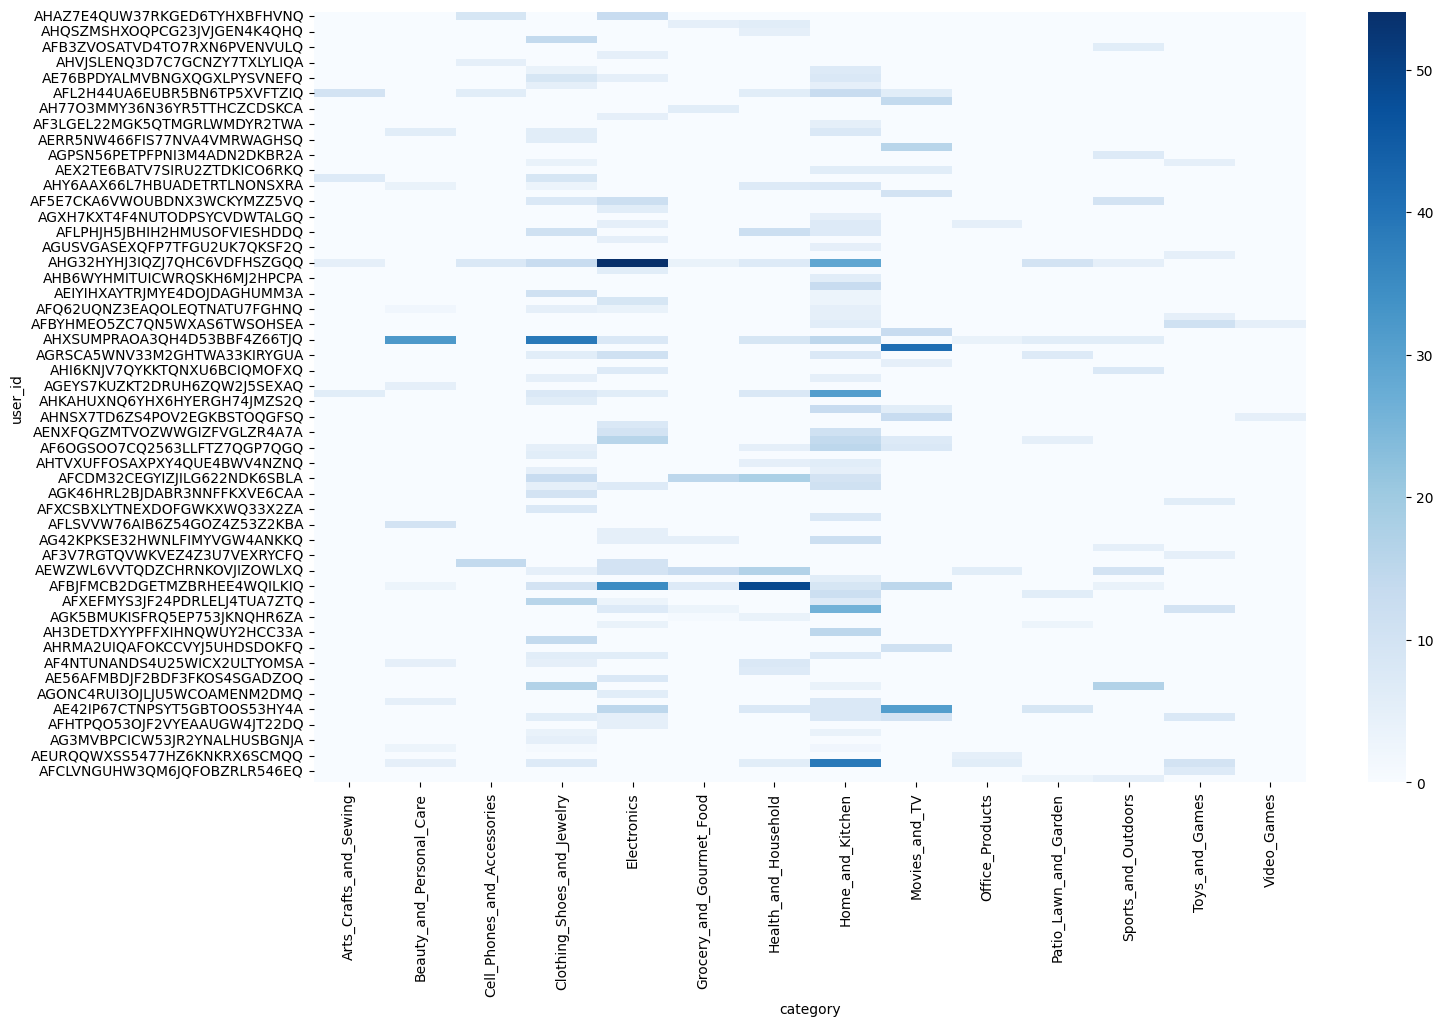

In [10]:
# plot user-item matrix to see how sparse data is

user_review_counts = train_df.groupby('user_id').size()
active_users = user_review_counts[user_review_counts >= 5].index

filtered_df = train_df[train_df['user_id'].isin(active_users)]

interaction = filtered_df.pivot_table(index='user_id', columns='category', values='rating', aggfunc='count', fill_value=0)
plt.figure(figsize=(16, 10))

sns.heatmap(interaction.sample(100), cmap='Blues')  

As we expected, most of the matrix is empty (light blue and white). We also want to see how many of the users and products in the test data are not in the training data (matrix factorization does not work on new users and products).

In [6]:
# read test review data
fs = gcsfs.GCSFileSystem()

all_files = fs.glob("amazon-reviews-project/test_data/*.csv.gz")

test_dfs = []

for file in all_files:
    base = os.path.basename(file).replace(".csv.gz", "")
    category, _ = base.split('.', 1)

    with fs.open(file, 'rb') as f:
        df = pd.read_csv(f, compression='gzip')
        df['category'] = category

    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)

In [7]:
# calculate products/users in the test set that are not in the training set
cold_start_users = ~test_df['user_id'].isin(train_df['user_id'])
cold_start_items = ~test_df['parent_asin'].isin(train_df['parent_asin'])

print(f"Cold start users: {cold_start_users.mean():.2%}")
print(f"Cold start items: {cold_start_items.mean():.2%}")

Cold start users: 15.80%
Cold start items: 49.58%


This means there will be a lot of new items in the test data that the matrix factorization model never saw before (almost 50%!), which will cause errors if we don't remove them. To achieve this, we will remove users and products with a small number of reviews as they don't offer any substantial signal. In a production environment, you can just default to popularity recommendation for those new users.

In [3]:
user_counts = train_df['user_id'].value_counts()
product_counts = train_df['parent_asin'].value_counts()

In [6]:
# determining percentage of data removed if applying a filter
print((user_counts < 5).mean())
print((product_counts < 5).mean()) 

0.17637787209011244
0.10423791526259898


We will lose 10% of product data and 17% of user data, but the tradeoff is that sparsity will decrease.

In [4]:
min_reviews = 5

valid_users = user_counts[user_counts > min_reviews].index
valid_products = product_counts[product_counts > min_reviews].index

filtered_train_df = train_df[train_df["user_id"].isin(valid_users) & train_df["parent_asin"].isin(valid_products)]

In [11]:
# recalculating sparsity on filtered dataset
num_users = filtered_train_df['user_id'].nunique()
num_products = filtered_train_df['parent_asin'].nunique()
total_reviews = len(filtered_train_df)

print(1 - (total_reviews / (num_users  * num_products)))

0.9999913061019302


In [21]:
print(0.9999913061019302 - 0.9999950520946896)

-3.7459927594296616e-06


As the decrease in sparsity is minimal, and we do not want to remove more data, our Matrix Factorization will likely struggle to make accurate recommendations. However, it will still serve as a more informed baseline. We will start preprocessing the data now to prepare for input into our Matrix Factorization model.

We need to first encode our user and product ids as Matrix Factorization models require numeric indices for their rows and columns.

In [5]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

#matrix_df = filtered_train_df[["user_id", "parent_asin", "rating"]]
filtered_train_df["user_id_encoding"] = user_encoder.fit_transform(filtered_train_df["user_id"])
filtered_train_df["parent_asin_encoding"] = product_encoder.fit_transform(filtered_train_df["parent_asin"])

/var/tmp/ipykernel_100605/648928759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df["user_id_encoding"] = user_encoder.fit_transform(filtered_train_df["user_id"])
/var/tmp/ipykernel_100605/648928759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df["parent_asin_encoding"] = product_encoder.fit_transform(filtered_train_df["parent_asin"])


In [8]:
filtered_train_df[["parent_asin_encoding", "user_id_encoding", "parent_asin", "rating"]].head()

,parent_asin_encoding,user_id_encoding,parent_asin,rating
0,2017682,1463896,B096WPNG8Q,5.0
1,60778,1463896,B000BQT5IG,3.0
2,193885,1463896,B002FGU2MI,4.0
3,1236987,351939,B073V7N6RQ,5.0
4,1041951,351939,B01J0RIRUS,4.0


Now, we will build the user-product confidence matrix where the rows are the user ids, the columns are the product ids, and the value at each cell is the confidence of the interaction (how much the user liked the interaction). We will use the formula c_i = 1 + alpha * rating where alpha determines how much weight to give to our observed interactions. We will set alpha to 20 as a user's reviews are a good way of understanding whether they liked the product or not.

In [6]:
# calculate confidence scores
alpha = 20.0
filtered_train_df["confidence"] = 1 + alpha * filtered_train_df["rating"]

/var/tmp/ipykernel_50715/1812792556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df["confidence"] = 1 + alpha * filtered_train_df["rating"]


In [7]:
filtered_train_df.head()

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing,datetime,year,user_id_encoding,parent_asin_encoding,confidence
0,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B096WPNG8Q,5.0,1600542207688,None,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches",4.6,4.97,Mosser Lee,0,2020-09-19 19:03:27.688,2020,1463896,2017682,101.0
1,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B000BQT5IG,3.0,1602272552200,B096WPNG8Q,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ...",4.4,5.48,Combat,0,2020-10-09 19:42:32.200,2020,1463896,60778,61.0
2,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B002FGU2MI,4.0,1624053736863,B096WPNG8Q B000BQT5IG,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...,3.9,16.93,Swimline,0,2021-06-18 22:02:16.863,2021,1463896,193885,81.0
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B073V7N6RQ,5.0,1566941698710,None,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...,4.5,25.99,Raisman,0,2019-08-27 21:34:58.710,2019,351939,1236987,101.0
4,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B01J0RIRUS,4.0,1566941843328,B073V7N6RQ,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...,4.0,16.99,AUTOKAY,0,2019-08-27 21:37:23.328,2019,351939,1041951,81.0


In [11]:
# build a sparse user-product matrix
user_product_matrix = coo_matrix((filtered_train_df["confidence"], (filtered_train_df["user_id_encoding"], filtered_train_df["parent_asin_encoding"])))

user_product_csr = user_product_matrix.tocsr()

/var/tmp/ipykernel_6694/2229414506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df["confidence"] = 1 + alpha * filtered_train_df["rating"]


In [12]:
# save train sparse matrix for future computation
save_npz("saved_csr_matrices/user_product_train.npz", user_product_csr)

In [4]:
# first time running
model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15, use_gpu=False)

model.fit(user_product_csr)

model.save("saved_models/als_model.npz")

/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [2]:
# can load the model after the first time
model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15, use_gpu=False)
model.load("saved_models/als_model.npz")

/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


I want to see what these recommendations would look like for a single user.

In [20]:
# test on a single user
user_id = 42
recommended_products = model.recommend(user_id, user_product_csr[user_id], N=10, filter_already_liked_items=True)

In [21]:
# see all of the user's recommended products
item_ids, scores = recommended_products
decoded_ids = product_encoder.inverse_transform(item_ids)

unique_titles = filtered_train_df[['parent_asin', 'title']].drop_duplicates()

recommended_titles = unique_titles[unique_titles['parent_asin'].isin(decoded_ids)]

rec_df = pd.DataFrame({"parent_asin": decoded_ids, "score": scores})

rec_df = rec_df.merge(unique_titles, on="parent_asin", how="inner")

In [22]:
display(rec_df[["parent_asin", "title", "score"]])

,parent_asin,title,score
0,B0BS2ZMHCL,Western Digital 4TB WD Blue PC Internal Hard D...,0.559399
1,B00OAJ412U,SAMSUNG 850 EVO 250GB 2.5-Inch SATA III Intern...,0.522243
2,B00OBRE5UE,SAMSUNG 850 EVO 500GB 2.5-Inch SATA III Intern...,0.511992
3,B08SCF2HC2,SABRENT 3.5 Inch to x2 SSD / 2.5 Inch Internal...,0.479583
4,B09CKV22L7,Kingston HyperX FURY 16GB Kit (2x8GB) 1866MHz ...,0.448815
5,B0BV93KQZR,Cooler Master Hyper 212 EVO V2 CPU Air Cooler ...,0.443920
6,B09Z3BM734,Crucial RAM 16GB Kit (2x8GB) DDR3 1600 MHz CL1...,0.422584
7,B01MXSLM3Z,Kingston Digital 60GB SSDNow V300 SATA 3 2.5 (...,0.410805
8,B000OGX5AM,Arctic Silver 5 AS5-3.5G Thermal Paste,0.407582
9,B077BQL5G2,Ballistix Sport 16GB Kit (8GBx2) DDR3 1600 MT/...,0.407101


In [23]:
# see the products the user previously interacted with
original_user_id = user_encoder.inverse_transform([user_id])[0]

user_history = filtered_train_df[filtered_train_df["user_id"] == original_user_id][["parent_asin", "title", "rating"]]

display(user_history)

,parent_asin,title,rating
613586,B09DJ964V4,Morningstar SunSaver Duo 25A PWM Solar Charge ...,5.0
613587,B09SNTK1J9,Camco Replacement Cap Kit for Propane Tank Cov...,5.0
613588,B00G5G83NY,Aquascape - Beneficial Bacteria for Ponds - 8....,5.0
613589,B07DB4NR6K,"Conntek ASTT-30P RV Male Replacement Plug, 30-Amp",5.0
613590,B00OV7UPI0,Aura outdoor products Ash Remover Cleaning Too...,5.0
613591,B01N2G3PLP,Hipa 496894S 496894 493909 Air Filter for John...,5.0
19823667,B07QRCQTS8,UT Wire UTW-CPM5-GY Compact Cord Protector wit...,4.0
19823668,B0BGNG1294,"Amazon Basics HDMI Cable, 18Gbps High-Speed, 4...",5.0
19823669,B01M70M9QT,Gigabyte AM3+ AMD 970 SATA 6Gbps USB 3.0 ATX A...,5.0
19823670,B00HJ1NQLS,Sunhans Sh-2500 2500mw Wireless Signal Repeate...,4.0


The user previously interacted with a lot of technology (cables, wires, processors), so they were strongly recommended other technology (TVs, SSD). We can verify the quality of the model on all users by determining the hit rate and precision in the recommendations. To do so, we have to build a user-product matrix from the test set.

In [13]:
users_in_train = set(filtered_train_df["user_id"])
products_in_train = set(filtered_train_df["parent_asin"])

# need to ensure model is only tested on users/products it has seen before (matrix factorization can't generalize to new users/products)
filtered_test_df = test_df[test_df["user_id"].isin(users_in_train) & test_df["parent_asin"].isin(products_in_train)]

#filtered_test_df = filtered_test_df[["user_id", "parent_asin", "rating"]]
filtered_test_df["user_id_encoding"] = user_encoder.transform(filtered_test_df["user_id"])
filtered_test_df["product_id_encoding"] = product_encoder.transform(filtered_test_df["parent_asin"])

/var/tmp/ipykernel_6694/3368262081.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df["user_id_encoding"] = user_encoder.transform(filtered_test_df["user_id"])
/var/tmp/ipykernel_6694/3368262081.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df["product_id_encoding"] = product_encoder.transform(filtered_test_df["parent_asin"])


In [38]:
filtered_test_df.head()

,user_id,parent_asin,user_id_encoding,product_id_encoding,interaction
1,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,B075WTKK4T,4051690,1549895,1
2,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B0007XKHNA,2449789,59768,1
3,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B07QQB9Y1C,2449789,2001554,1
4,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B01EQHJH88,2449789,1180122,1
5,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B07DGRLJBX,2449789,1748779,1


In [14]:
# calculate confidence scores
alpha = 20.0
filtered_test_df["confidence"] = 1 + alpha * filtered_test_df["rating"]

# build a sparse user-product matrix with user_ids as rows, product_ids as columns, and the confidence score in each cell
user_product_test_matrix = coo_matrix((filtered_test_df["confidence"], (filtered_test_df["user_id_encoding"], filtered_test_df["product_id_encoding"])))

user_product_test_csr = user_product_test_matrix.tocsr()

/var/tmp/ipykernel_6694/3159947295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df["confidence"] = 1 + alpha * filtered_test_df["rating"]


In [15]:
# save test sparse matrix for future computation
save_npz("saved_csr_matrices/user_product_test.npz", user_product_test_csr)

In [3]:
# can load both train and test sparse matrices from memory for simplicity
user_product_csr = load_npz("saved_csr_matrices/user_product_train.npz")
user_product_test_csr = load_npz("saved_csr_matrices/user_product_test.npz")

In [7]:
# test evaluation
test_precision = precision_at_k(model, user_product_csr, user_product_test_csr, K=10, num_threads = 0)
test_MAP = mean_average_precision_at_k(model, user_product_csr, user_product_test_csr, K=10, num_threads = 0)
test_AUC = AUC_at_k(model, user_product_csr, user_product_test_csr, 10, num_threads = 0)

In [19]:
print(f"Precision@{10}: {test_precision:.4f}")
print(f"MAP@{10}: {test_MAP:.4f}")
print(f"AUC: {test_AUC:.4f}")

Precision@10: 0.0039
MAP@10: 0.0019
AUC: 0.5020


These results show that the model does not perform very well:
- An AUC of 0.5 means the model's predictions are as good as randomly recommending products to users.
- The low MAP and Precision scores means that few recommendations are relevant, and those relevant recommendations are ranked very low in the recommendation ranking list.

However, it is important to keep in mind the built-in evaluation metrics in the Implicit library are very harsh, so low scores are expected. The problem is that they measure the ranking of the product compared to all products in the dataset. Since this dataset has hundreds of millions of products and the function is expecting an exact match for the product, it becomes very hard to distinguish relevant items in such a large pool. As a result, meaningful recommendations can be penalized simply because they don't appear in the very top of a massive ranking list.

We can make some optimizations to this model to enable better performance:
- remove the 25th percentile of user review counts and product review counts
    - we are removing the users and products with the least data, which trades real world application for increased performance
- modify the confidence score formula to incorporate the log function
    - reviews are positively skewed, so decreasing the impact of higher ratings and increasing the impact of lower ratings will boost performance
- decrease the alpha value in confidence formula (this will decrease the effect of skewed ratings)

We will reimplement the previous pipeline with the above modifications. A lot of the code will be similiar.

In [19]:
train_df_optimized = pd.read_parquet("gs://amazon-reviews-project/train_df.parquet", engine="pyarrow")

In [20]:
# filter 25th percentile of user and product counts
user_counts = train_df_optimized['user_id'].value_counts()
product_counts = train_df_optimized['parent_asin'].value_counts()

u_cut = user_counts.quantile(0.25)
p_cut = product_counts.quantile(0.25)

valid_users = user_counts[user_counts >= u_cut].index
valid_products = product_counts[product_counts >= p_cut].index

filtered_train_df_optimized = train_df_optimized[train_df_optimized["user_id"].isin(valid_users) & train_df_optimized["parent_asin"].isin(valid_products)].copy()

In [21]:
# calculate new sparsity
num_users = filtered_train_df_optimized['user_id'].nunique()
num_products = filtered_train_df_optimized['parent_asin'].nunique()
total_reviews = len(filtered_train_df_optimized)
sparsity = 1 - (total_reviews / (num_users * num_products))
print(f"Sparsity after removing 25th-percentile: {sparsity:.6f}")

Sparsity after removing 25th-percentile: 0.999993


In [22]:
# encode IDs
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

filtered_train_df_optimized["user_id_encoding"] = user_encoder.fit_transform(filtered_train_df_optimized["user_id"])
filtered_train_df_optimized["parent_asin_encoding"] = product_encoder.fit_transform(filtered_train_df_optimized["parent_asin"])

In [23]:
# calculate new confidence scores
alpha = 10 # decreased alpha to 10

# added log(rating) to confidence formula
filtered_train_df_optimized["confidence"] = 1.0 + alpha * np.log1p(filtered_train_df_optimized["rating"])

In [24]:
# build a sparse user-product matrix for training data
user_product_matrix_optimized = coo_matrix((filtered_train_df_optimized["confidence"],(filtered_train_df_optimized["user_id_encoding"], filtered_train_df_optimized["parent_asin_encoding"])))

user_product_csr_optimized = user_product_matrix_optimized.tocsr()

In [25]:
optimized_model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=20, use_gpu=False)
optimized_model.fit(user_product_csr_optimized)
optimized_model.save("saved_models/als_model_optimized.npz")

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
# if necessary 
optimized_model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=20, use_gpu=False)
optimized_model.load("saved_models/als_model_optimized.npz")

/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [26]:
# read test data
fs = gcsfs.GCSFileSystem()
all_files = fs.glob("amazon-reviews-project/test_data/*.csv.gz")

test_dfs_optimized = []
for file in all_files:
    base = os.path.basename(file).replace(".csv.gz", "")
    category, _ = base.split('.', 1)

    with fs.open(file, 'rb') as f:
        df = pd.read_csv(f, compression='gzip')
        df['category'] = category
    test_dfs_optimized.append(df)

test_df_optimized = pd.concat(test_dfs_optimized, ignore_index=True)

In [27]:
# restrict test to users/items only seen in training data
users_in_train = set(filtered_train_df_optimized["user_id"])
products_in_train = set(filtered_train_df_optimized["parent_asin"])

filtered_test_df_optimized = test_df_optimized[test_df_optimized["user_id"].isin(users_in_train) & test_df_optimized["parent_asin"].isin(products_in_train)].copy()

In [28]:
# encode with the same encoders as training
filtered_test_df_optimized["user_id_encoding"] = user_encoder.transform(filtered_test_df_optimized["user_id"])
filtered_test_df_optimized["parent_asin_encoding"] = product_encoder.transform(filtered_test_df_optimized["parent_asin"])

In [29]:
# calculate confidence scores
alpha = 20.0
filtered_test_df_optimized["confidence"] = 1 + alpha * filtered_test_df_optimized["rating"]

# build a sparse user-product matrix with user_ids as rows, product_ids as columns, and the confidence score in each cell
user_product_test_matrix_optimized = coo_matrix((filtered_test_df_optimized["confidence"], (filtered_test_df_optimized["user_id_encoding"], filtered_test_df_optimized["parent_asin_encoding"])))

user_product_test_csr_optimized = user_product_test_matrix_optimized.tocsr()

In [30]:
# free intermediate RAM
del train_df_optimized, test_df_optimized, filtered_train_df_optimized, filtered_test_df_optimized
gc.collect()

15

Now, we have trained an optimized matrix factorization model. We will evaluate the model on several metrics used in the industry to score recommendation quality:
- Precision at k: Out of the top k items the model recommends for a user, how many are actually relevant (items the user interacted with or liked)?
- Mean Average Precision at k: Similar to Precision at k, but also accounts for the order of correct recommendations (higher score for ranking relevant items higher in the recommendation order)
- AUC at K: Measures the probability that, out of the top k recommendations, a randomly chosen relevant item is ranked higher than a randomly chosen irrelevant item

In [39]:
# evaluate model on random sample of training data (100,000 data points) as evaluating on entire training dataset is unfeasible
active_users = np.where(user_product_csr_optimized.getnnz(axis=1) > 0)[0]

subset_users = np.random.choice(active_users, size=100000, replace=False)
user_product_subset = user_product_csr_optimized[subset_users, :]

empty_mask_subset = csr_matrix(user_product_subset.shape, dtype=user_product_subset.dtype)

# evaluate on different metrics
train_precision_optimized = precision_at_k(optimized_model, empty_mask_subset, user_product_subset, K = 10, num_threads = 0, show_progress = True)

train_MAP_optimized = mean_average_precision_at_k(optimized_model, empty_mask_subset, user_product_subset, K = 10, num_threads = 0, show_progress = True)

train_AUC_optimized = AUC_at_k(optimized_model, empty_mask_subset, user_product_subset, K = 10, num_threads = 0, show_progress = True)

print("=== Training Data Evaluation ===")
print(f"Precision@10: {train_precision_optimized:.4f}")
print(f"MAP@10:       {train_MAP_optimized:.4f}")
print(f"AUC@10:       {train_AUC_optimized:.4f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

=== Training Data Evaluation ===
Precision@10: 0.0019
MAP@10:       0.0007
AUC@10:       0.5005


In [ ]:
# evaluate model on entire test data
test_precision_optimized = precision_at_k(optimized_model, user_product_csr_optimized, user_product_test_csr_optimized, K=10, num_threads = 0, show_progress =True)
test_MAP_optimized = mean_average_precision_at_k(optimized_model, user_product_csr_optimized, user_product_test_csr_optimized, K=10, num_threads = 0, show_progress =True)
test_AUC_optimized = AUC_at_k(optimized_model, user_product_csr_optimized, user_product_test_csr_optimized, 10, num_threads = 0, show_progress =True)

  0%|          | 0/1261678 [00:00<?, ?it/s]

  0%|          | 0/1261678 [00:00<?, ?it/s]

In [36]:
print("=== Testing Data Evaluation ===")
print(f"Precision@{10}: {test_precision_optimized:.4f}")
print(f"MAP@{10}: {test_MAP_optimized:.4f}")
print(f"AUC: {test_AUC_optimized:.4f}")

=== Testing Data Evaluation ===
Precision@10: 0.0038
MAP@10: 0.0019
AUC: 0.5020


We can see the optimized model performed the same as the original model on the testing data:

Optimized Model:
- Precision@10: 0.0038
- MAP@10: 0.0019
- AUC: 0.5020

Original Model:
- Precision@10: 0.0039
- MAP@10: 0.0019
- AUC: 0.5020

Interpretation:
- Precision@10: Only about 0.38% of the items in the top 10 recommendations per user are actually relevant.
- MAP@10: Relevant items tend to appear towards the end of the recommendation order.
- AUC: The model is only slightly better than randomly guessing where to rank products.

These extremely low numbers means both models are severely underfitting. This is further proven by the the fact that the model's evaluation on both the training and testing data is similarly bad, showing the model did not perform any better on data it should have already learned. This makes sense, as we knew from the beginning of this notebook that most of the user-item matrix that our matrix factorization model used to learn interactions was empty. This means the main problem is a data quantity issue, and the modifications we made were not enough to overcome it. As it is not possible to acquire more data (we can not force users to interact with more products), we must use other parts of the data we have not been incorporating as of now (user and item metadata). In the next notebooks, we will implement the LightFM model which incorporates these metadata features to hopefully achieve better results.